<a href="https://colab.research.google.com/github/kor-zina/Numerical-methods/blob/master/Heat_transfer_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Компьютерный практикум 2021-2022

### Используемые модули

- `numpy`
- `numba`
- `holoviews` (`bokeh`/`matplotlib`)
- `tqdm`


### Задача о распространении тепла

**Дано:**

Изолированный бокс, в котором расположена текстолитовая подложка, покрытая медным слоем.
Размеры подложки: $100$ $мм$ х $50$ $мм$.

На подложке расположены:

Прибор А:
- рассеивает тепло на медном слое величиной $\frac{\dot{q}}{c_p \rho} = 100$ $К / с$
- размеры $5$ $мм$ x $5$ $мм$
- координаты центра: ($25$ $мм$, $35$ $мм$)

Прибор Б:
- координаты центра: ($75$ $мм$, $15$ $мм$),
- размером можно пренебречь,
- запрещено нагревать более, чем на $10$ градусов в течение $100$ секунд.

Посередине подложки ($x = 50$ $мм$) находится вертикальный ряд из $n$ отверстий размерами $1.5$ $мм$ x $2$ $мм$.
Отверстия:
- ухудшают механические свойства подложки, поэтому их должно быть минимальное количество.
- затрудняют передачу тепла от прибора А к прибору Б, и чем их больше, тем меньшее кол-во тепла будет передано.


**Необходимо** рассчитать минимальное количество отверстий $n$, при котором нагрев прибора Б не превысит $10$ градусов за $100$ секунд.

### Теоретическое введение

Распространение тепла можно описать при помощи уравнения диффузии (двумерный случай):

$\frac{\partial{T}}{\partial{t}} = D \left(\frac{\partial^2{T}}{\partial{x^2}} + \frac{\partial^2{T}}{\partial{y^2}} \right) + \frac{1}{c_p \rho} \cdot \dot{q}$, где

- $T(t, x, y)$ - поле температур
- $D(x, y)$ - коэффициент диффузии
- $\dot q(t, x, y)$ - функция источников тепла

Для решения задачи распространения тепла рассматриваемое тело представляют в виде двумерной сетки с равномерным шагом, а дифференциальное уравнение заменяют на конечно-разностное.
Рассмотрим схему `FTCS`, т.е. производная по времени заменяется на правую разность (`Forward Time`), а вторая производная по пространственным переменным заменяется на центральную разность (`Central Space`).

$\frac{\partial{T}}{\partial{t}} \rightarrow \frac{T^{n}_{i,j} - T^{n-1}_{i,j}}{dt}$

$\frac{\partial^2{T}}{\partial{x^2}} \rightarrow \frac{T^{n-1}_{i-1,j} - 2T^{n-1}_{i,j} + T^{n-1}_{i+1,j}}{dx^2}, ...$

$\frac{T^{n}_{i,j} - T^{n-1}_{i,j}}{dt} = \frac{D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{1}{c_p \rho} \cdot \dot{q}$

Итоговая рекуррентная формула для вычисления температуры в момент времени $n \cdot dt$ в ячейке сетки $(i, j)$ на основании данных в момент времени $(n-1) \cdot dt$:

$T^{n}_{i,j} = T^{n-1}_{i,j} + \frac{dt D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{dt}{c_p \rho} \cdot \dot{q}^{n}_{i,j}$

Временной шаг $dt$ должен быть таким, чтобы учитывать условие Курранта: $dt \leq \frac{C \cdot dx^2}{D_{max}}$, где $C$ - число Курранта.

В этой задаче рассматриваются граничные условия двух видов - фиксированная температура и абсолютная теплоизоляция. Оба вида граничных условий указаны на ребрах прямоугольной области. Таким образом, расчет распространения тепла выполняется для всех ячеек сетки, за исключением расположенных на ребрах прямоугольной области, т.е. $i, j \in (0, N-1)$, где $N = L / dx$.

Граничное условие в виде фиксированной температуры записывается в ячейки сетки, соответствующие ребрам прямоугольной области:

Например, для грани $x = 0$: $T^{n}_{0,j} = T_*$, грани $x = L$: $T^{n}_{N-1,j} = T_*$. 


Граничное условие в виде абсолютной теплоизоляции означает, что через заданную грань нет потока тепла, а это достижимо, если температура в ячейках грани и прилегающим к ним ячейкам одинаковая:

Например, $x = 0$: $T^{n}_{0,j} = T^{n}_{1,j}$, грани $x = L$: $T^{n}_{N-1,j} = T^{n}_{N-2,j}$.

$D = \frac{\kappa}{c_p \rho}$

- $\kappa$ - коэфф. теплопроводности
- $c_p$ - удельная теплоемкость
- $\rho$ - плотность

### Коэффициент температуропроводности материалов

$D_{медь} = 1.11 \cdot 10^{-4}$ $м^2 / c$

$D_{текстолит} = 1.54 \cdot 10^{-7}$ $м^2 / c$


### Ссылки

- [Solving 2D Heat Equation Numerically using Python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)

### Numpy версия
```
def diffuse_step_numpy(ti, T):
    ti = ti % 2
    tj = (ti + 1) % 2
    g = dt * D / dx**2
    T[tj, 1:-1, 1:-1] = T[ti, 1:-1, 1:-1] + \
                        g * (T[ti, 2:,   1:-1] + 
                             T[ti,  :-2, 1:-1] + 
                             T[ti, 1:-1, 2:  ] + 
                             T[ti, 1:-1,  :-2] - 
                             4*T[ti, 1:-1, 1:-1])
                             
T = np.zeros((2, ny, nx))

max_time = 100.0
iterations = int(max_time / dt)
print(iterations)

# граничные условия
T[:,  0,  :] = 0.0
T[:, -1,  :] = 100.0
T[:,  :,  0] = 0.0
T[:,  :, -1] = 0.0

for i in trange(iterations):
    diffuse_step_numpy(i, T)
```

### Решение задачи

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
from tqdm import trange, tqdm

### Константы

In [ ]:
Dcu = 1.11e-4
Dtex = 1.54e-7


L, H = 0.1, 0.05
nx, ny = 200, 100
dx = L / nx
dx

0.0005

In [ ]:
pos = np.array([25e-3 / dx, 35e-3 / dx], dtype=int)
size = np.array([5e-3 / dx, 5e-3 / dx], dtype=int)
pos, size

(array([50, 70]), array([10, 10]))

In [ ]:
probe = np.array([75e-3 / dx, 15e-3 / dx], dtype=int)
probe

array([150,  30])

In [ ]:
hx = int(1.5e-3 / dx)
hy = int(2e-3 / dx)
hx, hy

(3, 4)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
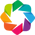

:Overlay
   .Image.I  :Image   [x,y]   (z)
   .Points.I :Points   [x,y]

In [ ]:
Dxy = np.full((ny, nx), Dcu, dtype=float)

n = 2
dh = ny // n
c = nx // 2
for i in range(hy):
    Dxy[dh//2-hy//2+i::dh, c-hx//2:c+hx//2] = Dtex

hv.extension('bokeh')
hv.Image(Dxy[::-1], bounds = (0, 0, L, H)).opts(colorbar=True, width=500, height=200) * \
hv.Points({'x':[probe[0] * dx], 'y':[probe[1] * dx]})

In [ ]:
def diffuse_step_numpy(ti, T):
    ti = ti % 2
    tj = (ti + 1) % 2
    g = dt * Dxy[1:-1, 1:-1] / dx**2
    T[tj, 1:-1, 1:-1] = T[ti, 1:-1, 1:-1] + \
                        g * (T[ti, 2:,   1:-1] + 
                             T[ti,  :-2, 1:-1] + 
                             T[ti, 1:-1, 2:  ] + 
                             T[ti, 1:-1,  :-2] - 
                             4*T[ti, 1:-1, 1:-1])

from numba import njit, prange

@njit(parallel = True)
def diffuse_step_par(ti, T, Dxy):
    ti = ti % 2
    tj = (ti + 1) % 2
    
    for i in prange(1, ny-1):
        for j in range(1, nx-1):
    
            g = dt * Dxy[i, j] / dx**2
            T[tj, i, j] = T[ti, i, j] + \
                     g * (T[ti, i+1, j] + 
                          T[ti, i-1, j] + 
                          T[ti, i, j+1] + 
                          T[ti, i, j-1] - 
                        4*T[ti, i, j])

    
max_time = 100.0
dt = dx**2 / (4 * Dxy.max())
iterations = int(max_time / dt)
print(iterations)

def isolation(T):
    T[:,  0] = T[:,  1]
    T[:, -1] = T[:, -2]
    T[:, :,  0] = T[:, :,  1]
    T[:, :, -1] = T[:, :, -2]


left = pos[0] - size[0]//2
right = left + size[0]
bottom = pos[1] - size[1]//2
top = bottom + size[1]
power = 100.0

def source(T, power):
    T[:, bottom:top, left:right] += dt * power

177600


In [ ]:
def plot(data):
    return hv.Image(T[0, ::-1])

pipe = hv.streams.Pipe()

hv.DynamicMap(plot, streams = [pipe]).opts(width=400, height=200, cmap='jet')

:DynamicMap   []
   :Image   [x,y]   (z)

In [ ]:
T = np.zeros((2, ny, nx), dtype=float)
temps = []

for i in trange(iterations):
    source(T, power)
    diffuse_step_par(i, T, Dxy)
    isolation(T)
    temps.append(T[(i + 1)%2, probe[1], probe[0]])
    if i % (iterations // 50) == 0:
        pipe.send(0)

100%|███████████████████████████████████████████████████████████████████████| 177600/177600 [00:07<00:00, 22983.84it/s]


In [ ]:
hv.Curve({'x':np.arange(len(temps))*dt, 'y':temps})

:Curve   [x]   (y)

In [ ]:
def probe_temp(n):
    T = np.zeros((2, ny, nx), dtype=float)
    Dxy = np.full((ny, nx), Dcu, dtype=float)
    
    dh = ny // n
    c = nx // 2
    for i in range(hy):
        Dxy[dh//2-hy//2+i::dh, c-hx//2:c+hx//2] = Dtex
        
    for i in trange(iterations):
        source(T, power)
        diffuse_step_par(i, T, Dxy)
        isolation(T)
        
    return T[(i + 1)%2, probe[1], probe[0]]

In [ ]:
n_arr = np.arange(8, 15)
temps = []

for n in n_arr:
    temps.append(probe_temp(n))

100%|███████████████████████████████████████████████████████████████████████| 177600/177600 [00:07<00:00, 25335.23it/s]


In [ ]:
hv.Curve({'x':n_arr, 'y':temps}, ('x', 'n'), ('y', 'T'))

:Curve   [x]   (y)

In [ ]:
tarr = np.array(temps)
a = tarr - 10
idx = np.argmin(a[1:] * a[:-1]) + 1 
tarr[idx], n_arr[idx]

(9.355159879333993, 12)